In [21]:
import numpy as np
from cmaes import CMA
import matplotlib.pyplot as plt
import itertools
from scipy.optimize import curve_fit

from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

In [22]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [23]:
tuid = get_latest_tuid(contains="Single-shot")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 198kB
Dimensions:  (dim_0: 2744)
Coordinates:
    x0       (dim_0) float64 22kB 4.8e-08 1.04e-07 1.64e-07 ... 7.4e-07 7.96e-07
    x1       (dim_0) float64 22kB 7.37e+09 7.37e+09 ... 7.42e+09 7.42e+09
    x2       (dim_0) float64 22kB 0.005 0.005 0.005 0.005 ... 0.07 0.07 0.07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 22kB 0.5118 0.5128 0.5101 ... 0.7327 0.7516 0.5369
    y1       (dim_0) float64 22kB 0.511 0.5122 0.5066 ... 0.777 0.8044 0.5442
    y2       (dim_0) float64 22kB 0.5126 0.5181 0.5101 ... 0.8332 0.8606 0.5499
    y3       (dim_0) float64 22kB 0.5119 0.5083 0.5136 ... 0.588 0.5898 0.5166
    y4       (dim_0) float64 22kB 0.5 0.5063 0.5 0.503 ... 0.6812 0.7066 0.6645
    y5       (dim_0) float64 22kB 0.5039 0.5016 0.5063 0.5 ... 0.637 0.6667 0.5
Attributes:
    tuid:                             20241207-194048-547-5c7816
    name:                             Single-shot readout vs. pulse duration,...
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [27]:
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data

QND_pi_fidelity = dataset.y5.data

freq_reshape = []
amplitude_reshape = []
average_fidelity_reshape = []
QND_pi_fidelity_reshape = []

# Count occurrences
unique_duration_values, counts = np.unique(duration, return_counts=True)
print(unique_duration_values)

for i in unique_duration_values:
    indices = np.where(duration == i)
    freq_reshape.append(frequency[indices])
    amplitude_reshape.append(amplitude[indices])
    average_fidelity_reshape.append(average_fidelity[indices])
    QND_pi_fidelity_reshape.append(QND_pi_fidelity[indices])

[4.80e-08 1.04e-07 1.64e-07 2.20e-07 2.80e-07 3.36e-07 3.96e-07 4.52e-07
 5.08e-07 5.68e-07 6.24e-07 6.84e-07 7.40e-07 7.96e-07]


In [28]:
#For now just work with longest duration data:
duration = unique_duration_values[7]
print(duration)
frequency_test = freq_reshape[7]
amplitude_test = amplitude_reshape[7]
average_fidelity_test = average_fidelity_reshape[7]

4.52e-07


In [6]:
def plotSingleFidelity(frequency: np.ndarray, amplitude: np.ndarray, fidelity: np.ndarray, title: str) -> None:
    """
    Plot a single heatmap using imshow for frequency, amplitude, and fidelity.
    """
    # Reshape fidelity to 2D (if not already a grid)
    Z = fidelity.reshape(int(np.sqrt(len(amplitude))), int(np.sqrt(len(frequency))))

    # Calculate the extent of the axes for imshow
    dx = (frequency.max() - frequency.min()) / (Z.shape[1] - 1)  # Step size along x-axis
    dy = (amplitude.max() - amplitude.min()) / (Z.shape[0] - 1)  # Step size along y-axis

    extent = [
        frequency.min() - 0.5 * dx, frequency.max() + 0.5 * dx,  # x-axis range
        amplitude.min() - 0.5 * dy, amplitude.max() + 0.5 * dy   # y-axis range
    ]

    # Plot with imshow
    plt.figure(figsize=(10, 8), dpi=300)
    cmap = 'viridis'
    vmin, vmax = 0.5, 1  # Set fidelity range for consistent scaling

    im = plt.imshow(Z, extent=extent, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Fidelity")
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency [Hz]", fontsize=12)
    plt.ylabel("Amplitude [V]", fontsize=12)
    plt.show()

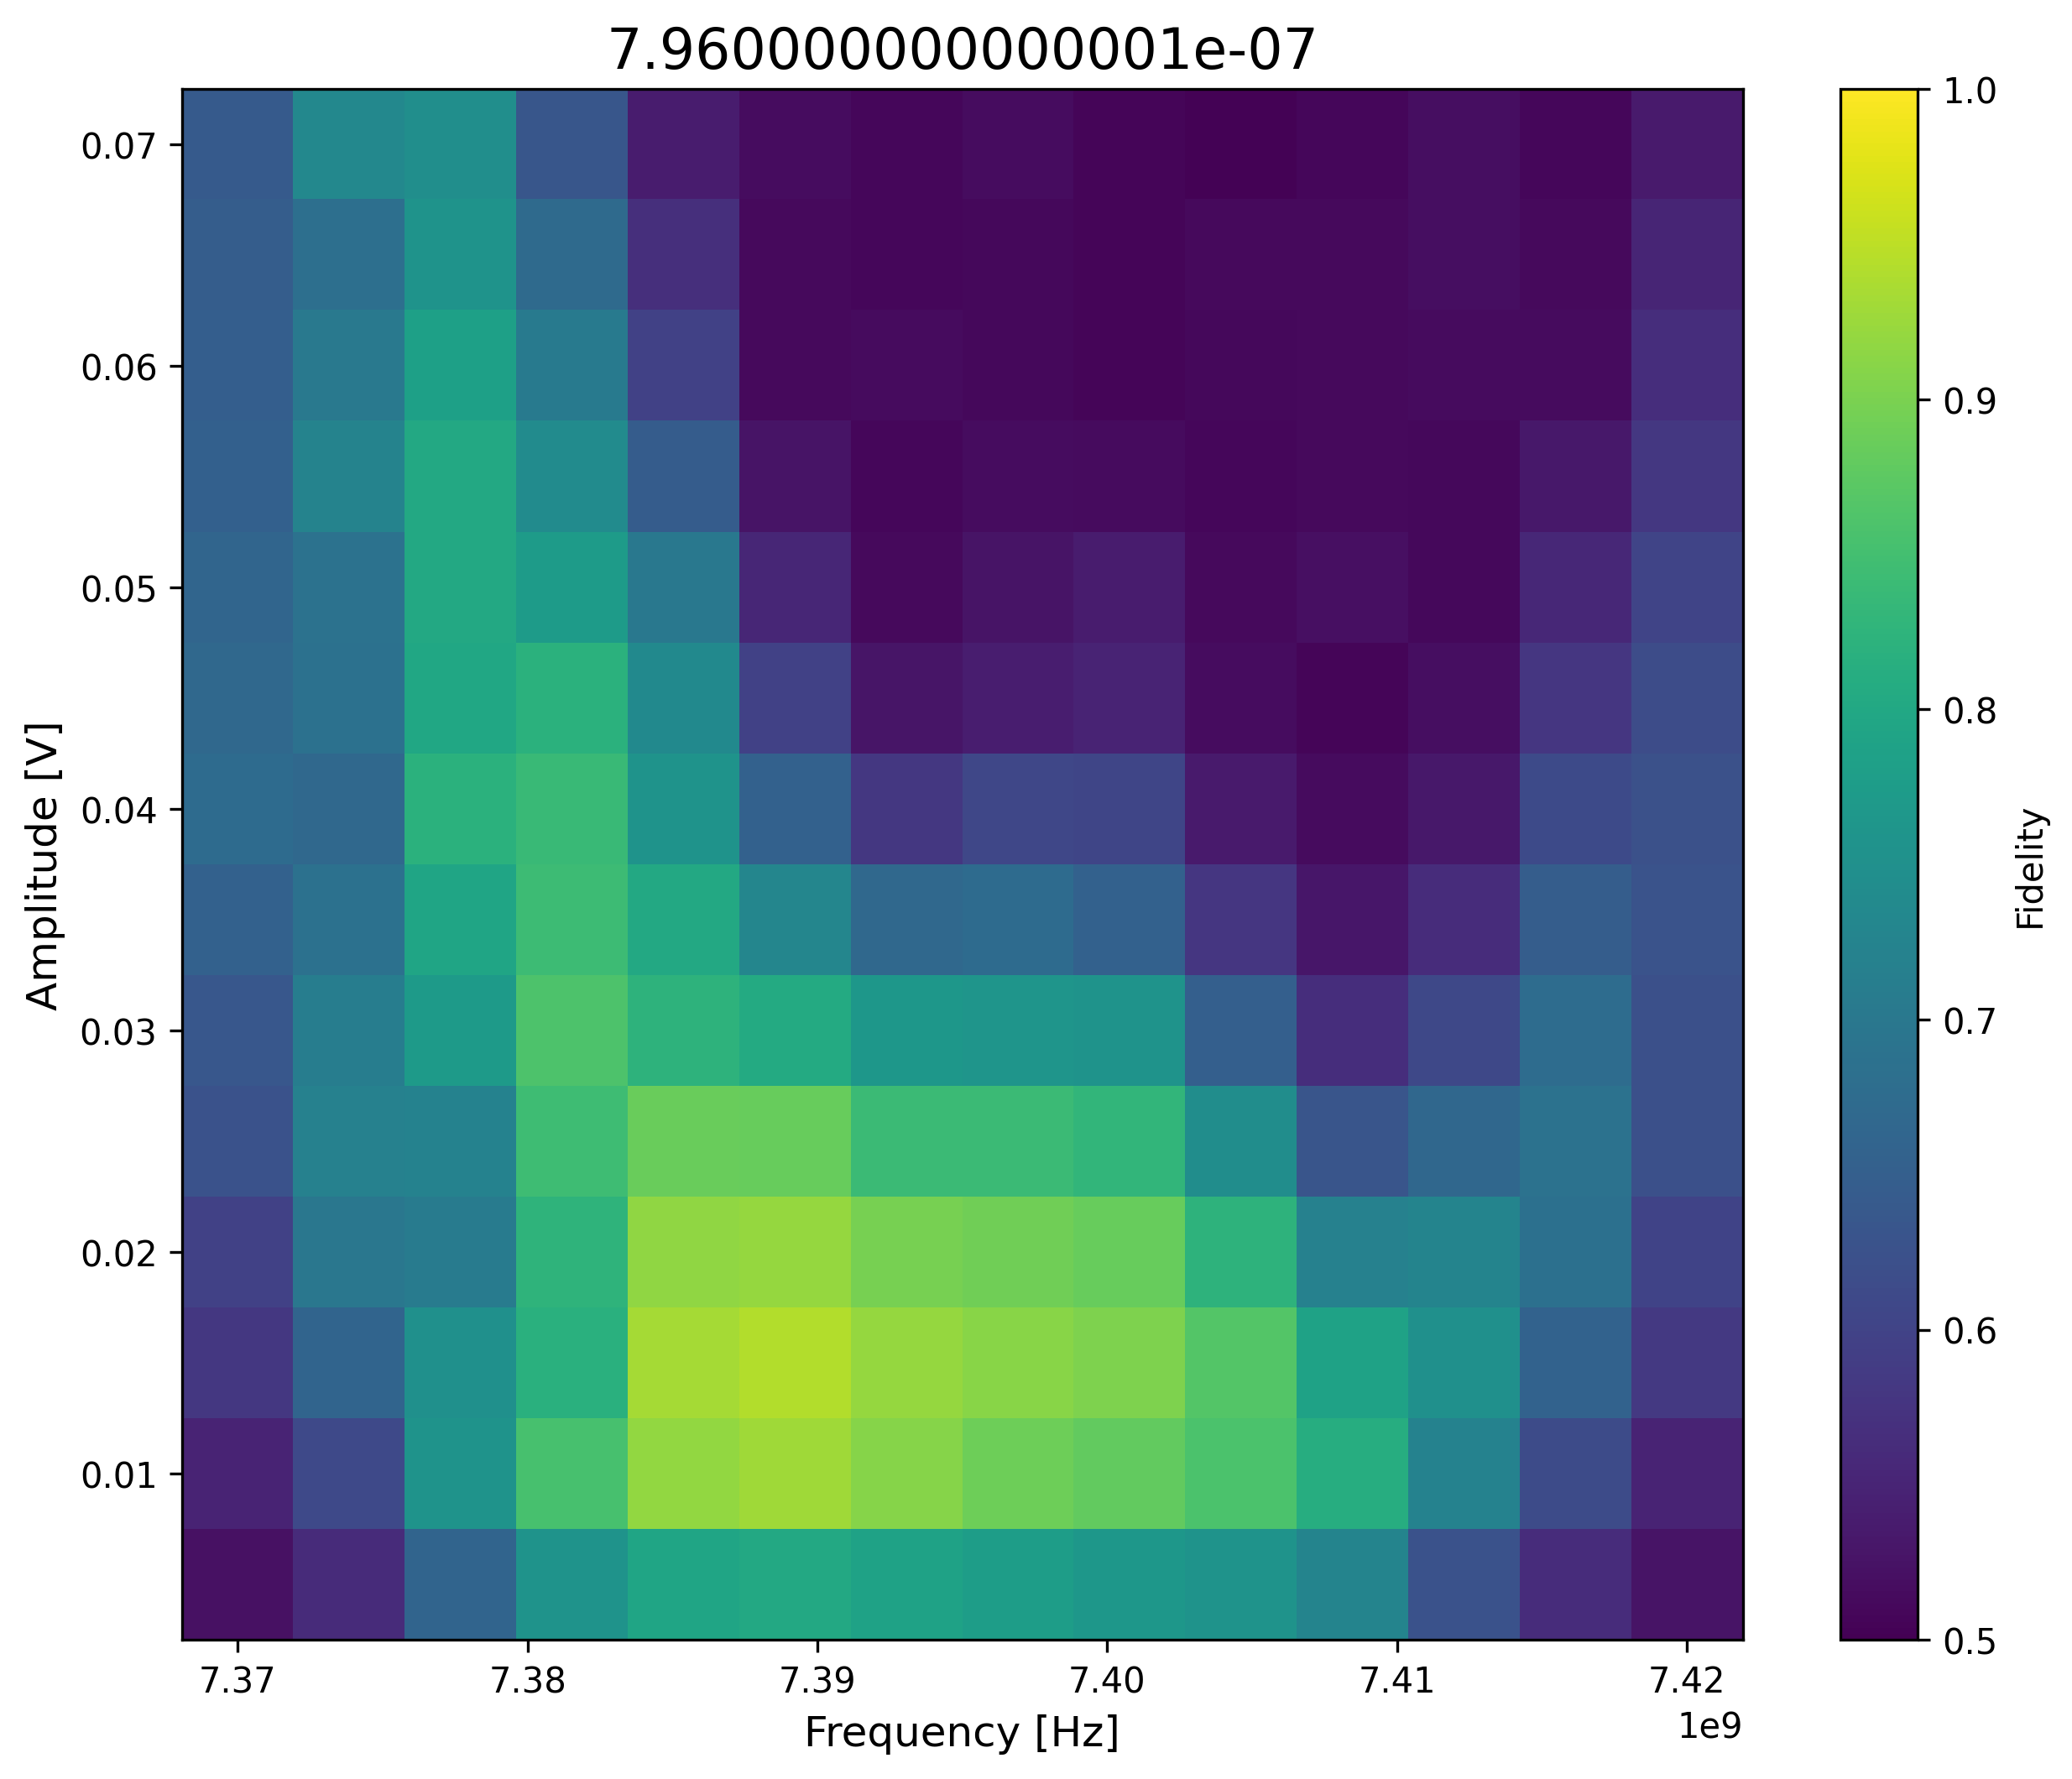

In [7]:
plotSingleFidelity(frequency_test,amplitude_test,average_fidelity_test,str(duration))

In [8]:
def fidelityEstimate(point,frequency,amplitude,fidelity):
    # Get unique values of frequency and amplitude
    unique_freq = np.unique(frequency)
    unique_ampl = np.unique(amplitude)
    
    # Get the closest 2 unique frequencies and amplitudes
    dFreq = np.abs(unique_freq - point[0])
    dAmpl = np.abs(unique_ampl - point[1])
    
    freqArgs = np.argsort(dFreq)[:2]
    amplArgs = np.argsort(dAmpl)[:2]
    
    x_coor = unique_freq[freqArgs]
    y_coor = unique_ampl[amplArgs]
    
    # Sort the coordinates
    sortedX = np.sort(x_coor)
    sortedY = np.sort(y_coor)
    
    # Calculate differences
    dx = np.diff(sortedX)
    dy = np.diff(sortedY)
    
    fidelities = []
    
    for i in itertools.product(sortedX,sortedY):
        temp1 = np.where(i[0] == frequency)
        temp2 = np.where(i[1] == amplitude)
        arg = np.intersect1d(temp1,temp2)
        fidelities.append(fidelity[arg])
    
    fidelities = np.array(fidelities)
    
    # Reshape fidelities into a 2x2 grid for interpolation
    fidelity_matrix = fidelities.reshape((2, 2))
    # print(fidelity_matrix)
    
    # Bilinear interpolation formula
    result = (fidelity_matrix[0, 0] * (sortedX[1] - point[0]) * (sortedY[1] - point[1]) +
              fidelity_matrix[1, 0] * (point[0] - sortedX[0]) * (sortedY[1] - point[1]) +
              fidelity_matrix[0, 1] * (sortedX[1] - point[0]) * (point[1] - sortedY[0]) +
              fidelity_matrix[1, 1] * (point[0] - sortedX[0]) * (point[1] - sortedY[0])) / (dx * dy)

    return result

33


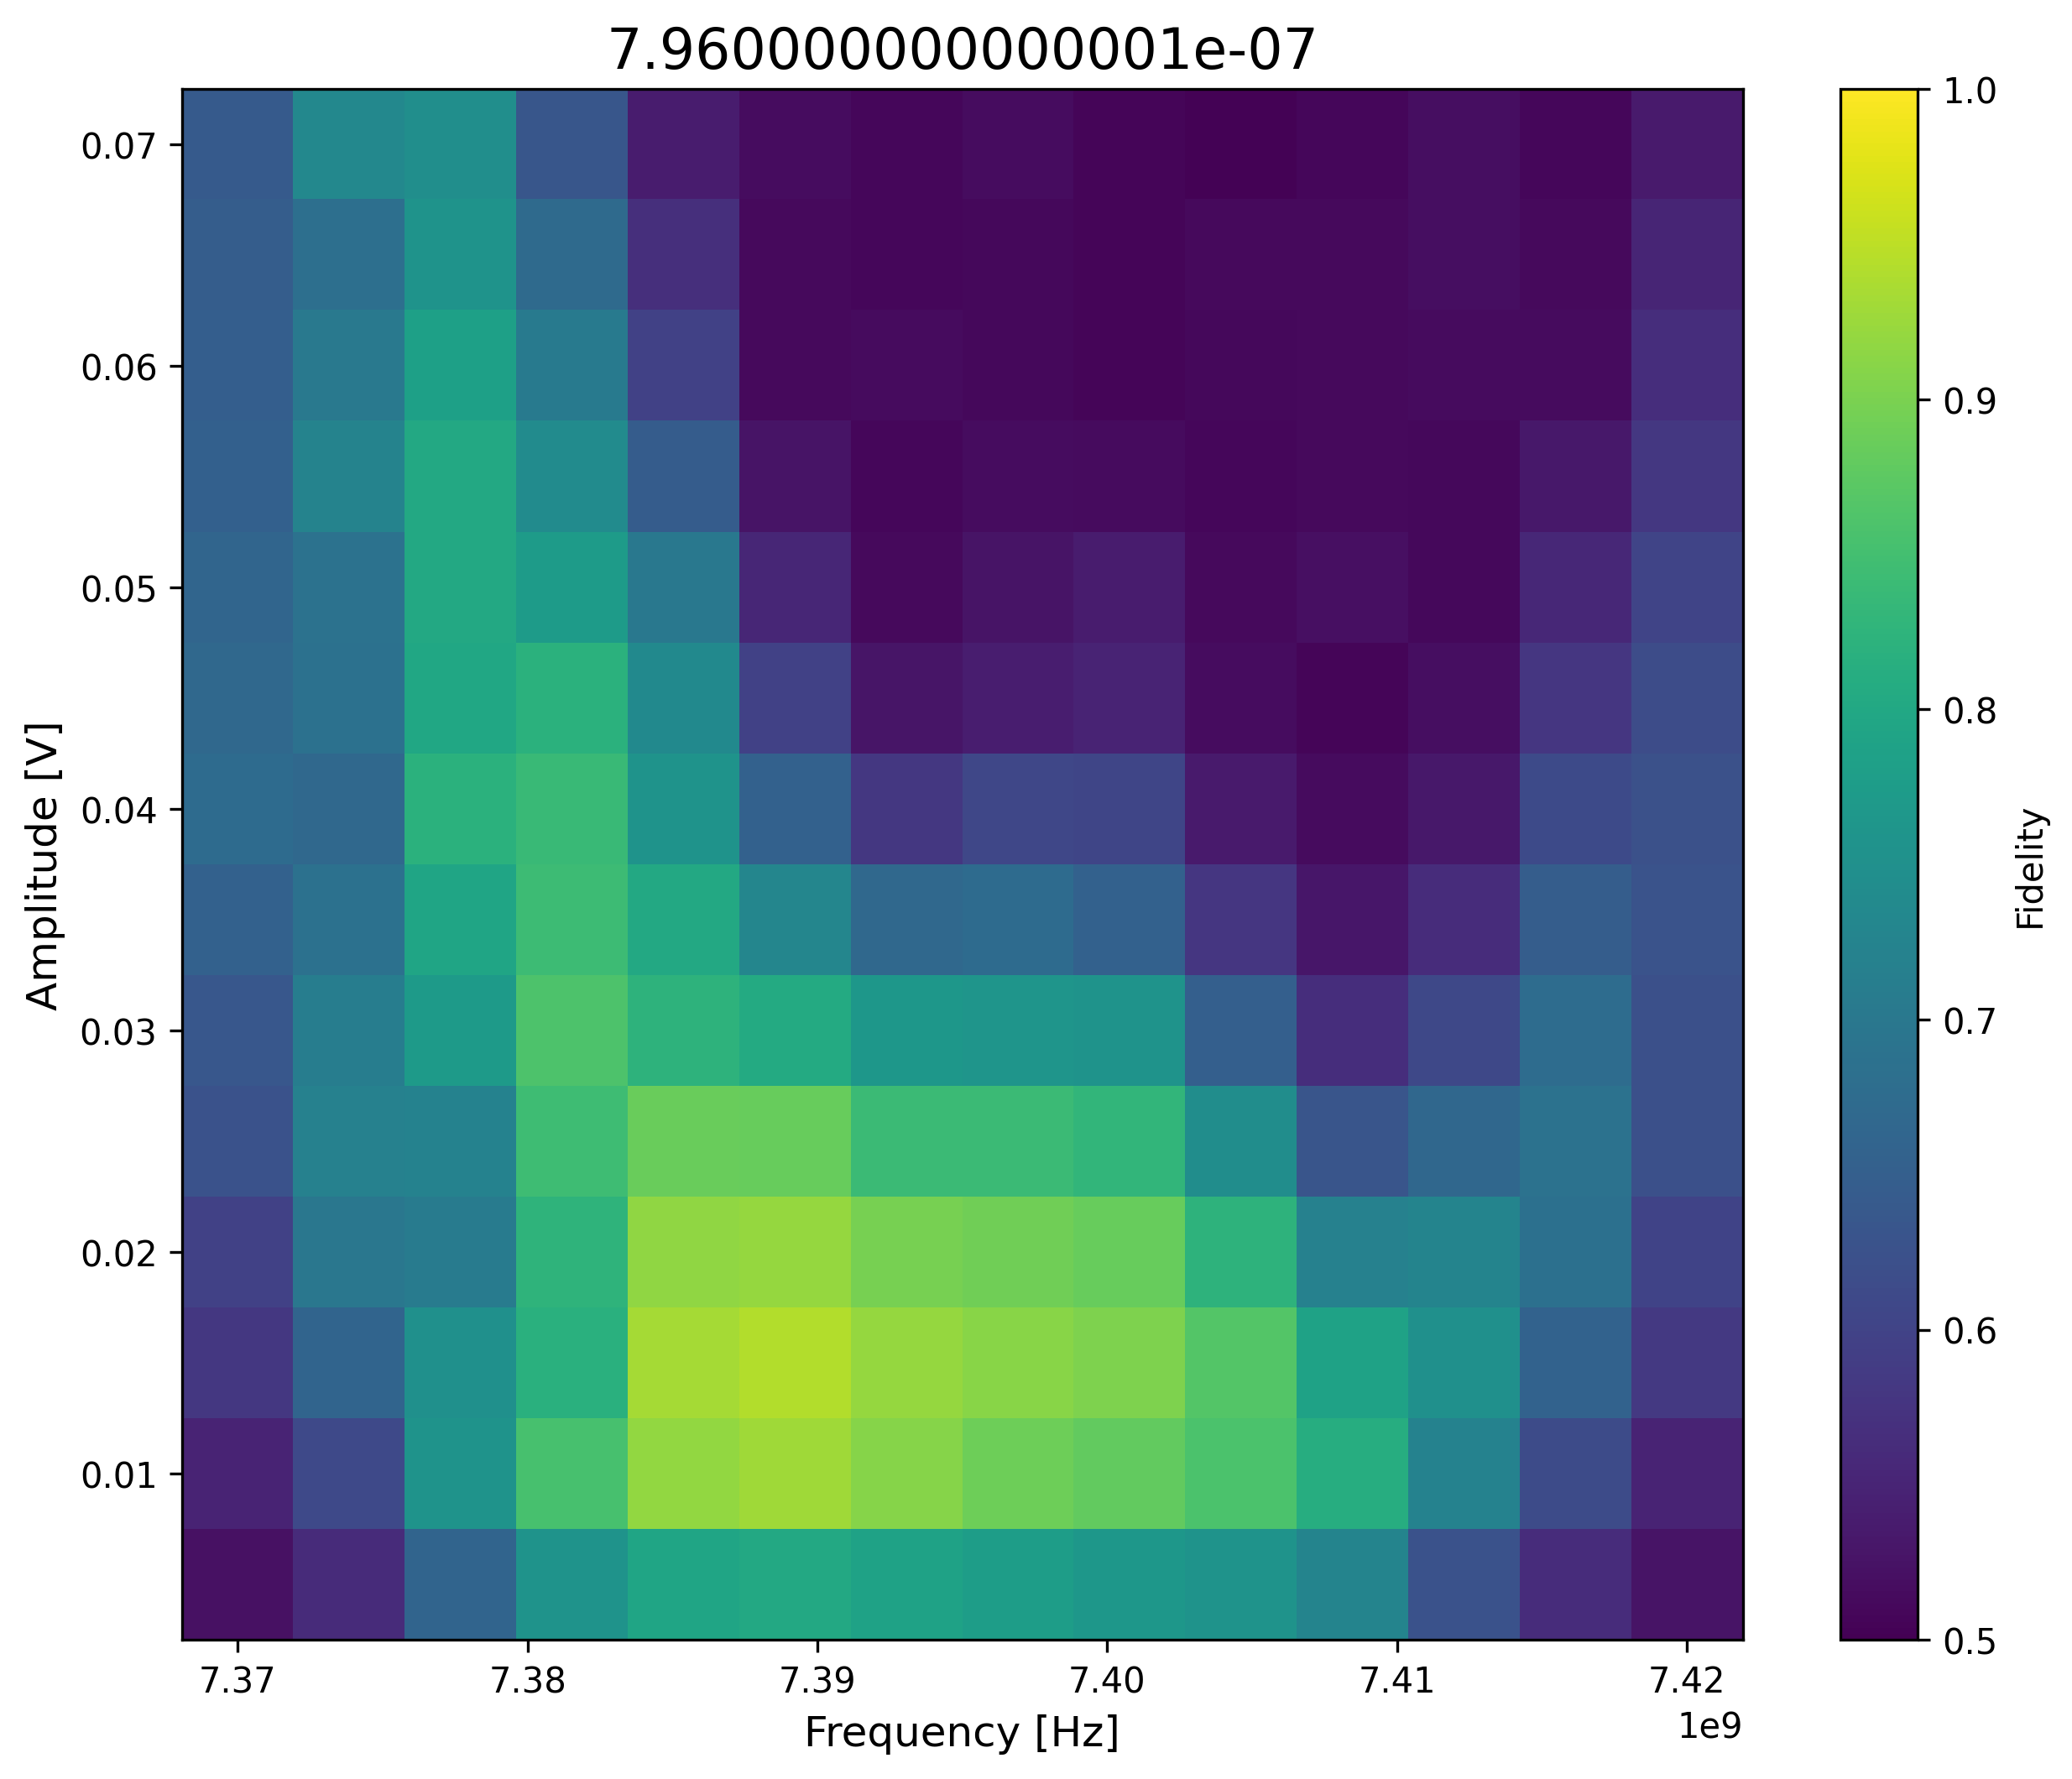

In [9]:
x = np.linspace(min(frequency_test),max(frequency_test),14)
y = np.linspace(min(amplitude_test),max(amplitude_test),14)

X0 = np.array(list(itertools.product(y,x)))
x = X0[:,1]
y = X0[:,0]

# print(amplitude_test)
# print(x)
# print(y)

# # x = frequency_test
# # y = amplitude_test

points = np.column_stack((x,y))
# print(points.shape)
# print(np.unique(points[:, 0]))
# print(np.unique(points[:, 1]))

fidelity_estimates = []

for point in points:
    estimate = fidelityEstimate(point, frequency_test, amplitude_test, average_fidelity_test)
    fidelity_estimates.append(estimate)

print(np.argmax(fidelity_estimates))
# print(len(fidelity_estimates))
plotSingleFidelity(x,y,np.array(fidelity_estimates),str(duration))

33


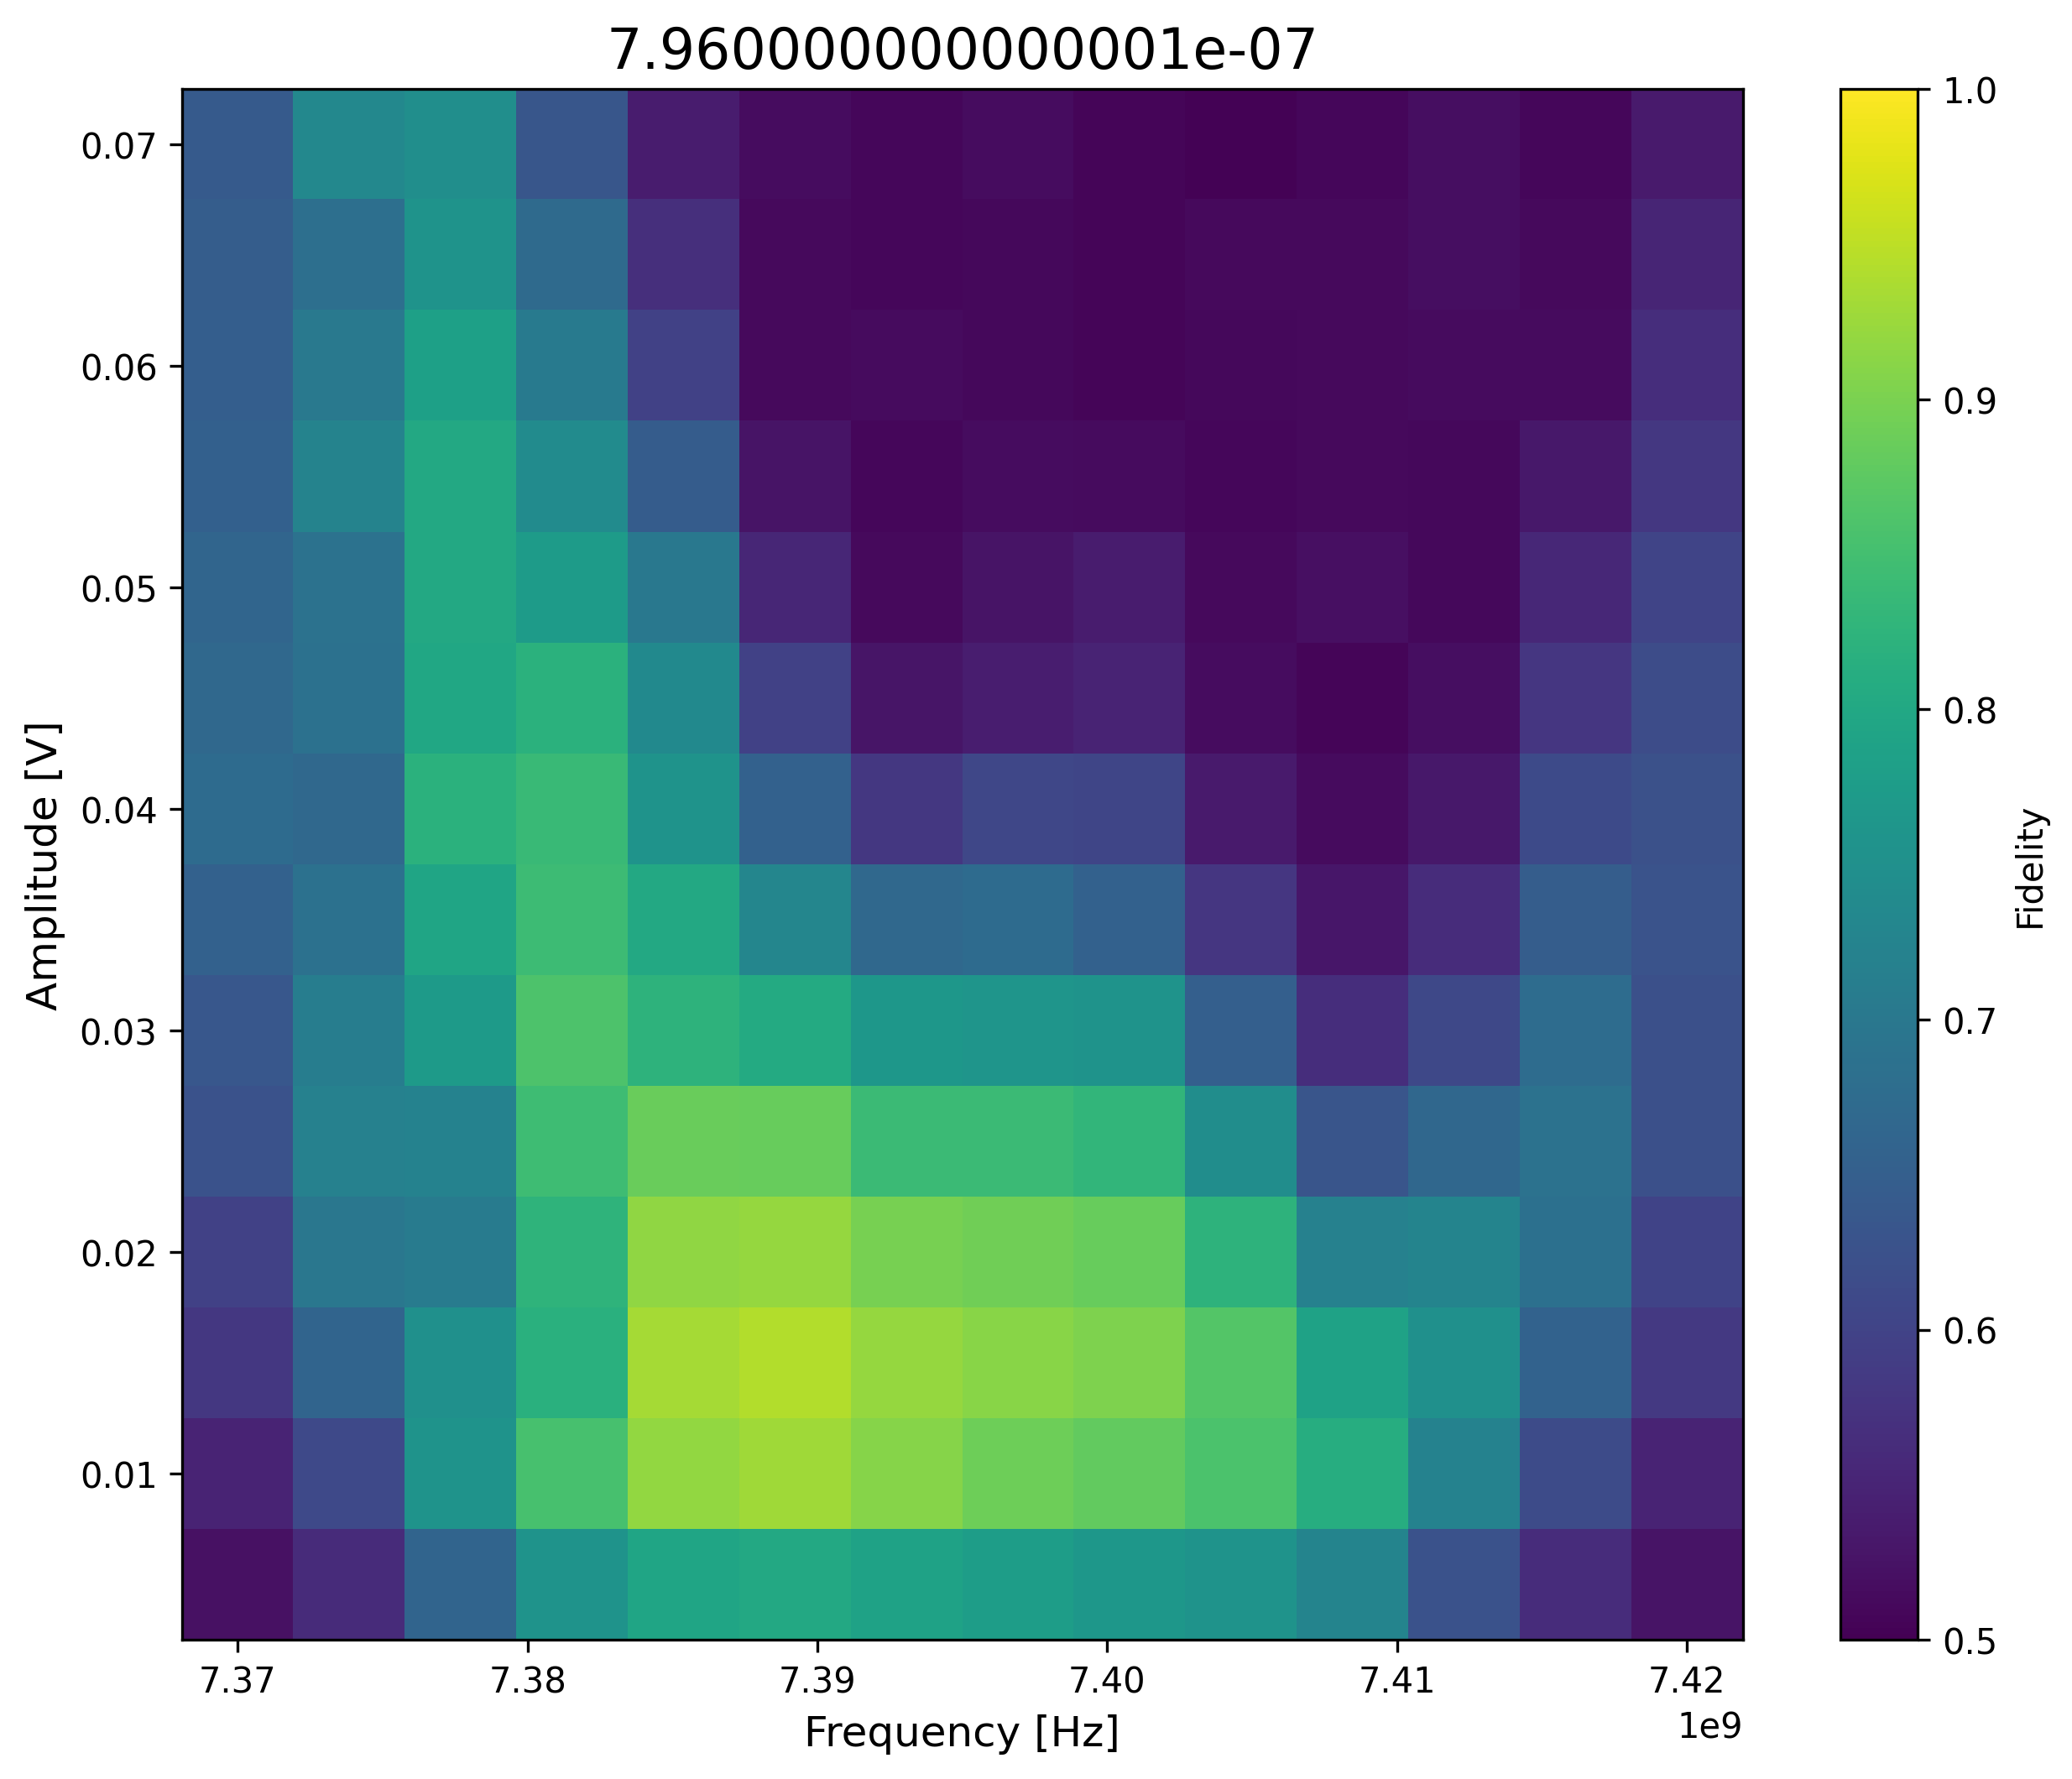

In [10]:
x = np.linspace(min(frequency_test),max(frequency_test),14)
y = np.linspace(min(amplitude_test),max(amplitude_test),14)

X0 = np.array(list(itertools.product(y,x)))
x = X0[:,1]
y = X0[:,0]

# print(amplitude_test)
# print(x)
# print(y)

# # x = frequency_test
# # y = amplitude_test

points = np.column_stack((x,y))
# print(points.shape)
# print(np.unique(points[:, 0]))
# print(np.unique(points[:, 1]))

fidelity_estimates = []

for point in points:
    estimate = fidelityEstimate(point, frequency_test, amplitude_test, average_fidelity_test)
    fidelity_estimates.append(estimate)

print(np.argmax(fidelity_estimates))
# print(len(fidelity_estimates))
plotSingleFidelity(x,y,np.array(fidelity_estimates),str(duration))

In [11]:
# def objective(point,frequency,amplitude,fidelity):
#     F = fidelityEstimate(point, frequency, amplitude, fidelity)
#     return np.log(1-F)

# popsize = 10
# sigma = 0.25 #1/4 of the domain 

# def cmaes(popsize: int, sigma: float, 
#     boundX = [0,1]
#     boundY = [0,1]
#     bounds = np.array([boundX,boundY])
    
#     mean = np.array([0.0,0.0])
    
#     optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize,bounds=bounds)
    
#     minFreq = min(frequency_test)
#     maxFreq = max(frequency_test)
#     deltaFreq = maxFreq-minFreq
    
#     minAmpl = min(amplitude_test)
#     maxAmpl = max(amplitude_test)
#     deltaAmpl = maxAmpl-minAmpl
    
#     Ngen = 50
    
#     maxFidelity = np.zeros(Ngen)
#     coordinate = np.zeros((Ngen,2))
#     meanFidelity = np.zeros(Ngen)
    
#     for generation in range(Ngen):
#         solutions = []
#         fid = 0
#         mean_hat = np.copy(optimizer.mean)
#         mean_hat[0] = mean_hat[0]*deltaFreq+minFreq
#         mean_hat[1] = mean_hat[1]*deltaAmpl+minAmpl
    
#         # meanFidelity[generation] = fidelityEstimate(mean_hat,frequency_test,amplitude_test,average_fidelity_test)[0]
    
#         for _ in range(optimizer.population_size):
#             x = optimizer.ask()
            
#             x_hat = np.copy(x)
#             x_hat[0] = x_hat[0]*deltaFreq+minFreq
#             x_hat[1] = x_hat[1]*deltaAmpl+minAmpl
    
#             value = objective(x_hat,frequency_test, amplitude_test,average_fidelity_test) #Change name in pycharm
#             # tmpFidelity = fidelityEstimate(x_hat,frequency_test,amplitude_test,average_fidelity_test)
    
#             # if tmpFidelity > fid:
#             #     maxFidelity[generation] = tmpFidelity[0]
#             #     coordinate[generation,:] = x_hat
                
#             #     fid = tmpFidelity
            
#             solutions.append((x,value))
        
#         optimizer.tell(solutions)

#     normalized_mean = optimizer.mean
#     mean = np.copy(normalized_mean)
#     mean[0] = mean[0]*deltaFreq+minFreq
#     mean[1] = mean[1]*deltaAmpl+minAmpl
#     return mean


# plt.plot(range(Ngen),maxFidelity)
# plt.xlabel("Generation")
# plt.ylabel("Average Fidelity")
# plt.title(f"mean = {mean.tolist() if isinstance(mean, np.ndarray) else mean}")
# plt.show()

In [12]:
def objective(points,frequency,amplitude,fidelity):
    objective = np.zeros(len(points))
    for i in range(len(points)):
        F = fidelityEstimate(points[i], frequency, amplitude, fidelity)
        objective[i] = np.log(1-F)[0]
    return objective
    
def cmaes_frequency_and_amplitude(mean, sigma, popsize, Ngen,  minFreq, maxFreq, minAmpl, maxAmpl):
    boundX = [0, 1]
    boundY = [0, 1]
    bounds = np.array([boundX, boundY])
    
    optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)

    deltaFreq = maxFreq - minFreq
    deltaAmpl = maxAmpl - minAmpl

    maxFidelity = np.zeros(Ngen)
    coordinate = np.zeros((Ngen, 2))
    meanFidelity = np.zeros(Ngen)

    for generation in range(Ngen):       
        normalized_freq = np.zeros(popsize)
        normalized_ampl = np.zeros(popsize)
        
        frequencies = np.zeros(popsize)
        amplitudes = np.zeros(popsize)
        
        for i in range(popsize):
            x = optimizer.ask()
            normalized_freq[i] = x[0]
            normalized_ampl[i] = x[1]

            frequencies[i] = x[0]*deltaFreq + minFreq
            amplitudes[i] = x[1]*deltaAmpl + minAmpl
                    
        normalized_freq_and_ampl = [(float(xi), float(yi)) for xi, yi in zip(normalized_freq, normalized_ampl)]
        freq_and_ampl = np.array([np.array([xi, yi]) for xi, yi in zip(frequencies, amplitudes)])
        # print(freq_and_ampl)
        objective_value = objective(freq_and_ampl,frequency_test, amplitude_test,average_fidelity_test)

        solutions = [(wi, float(vi)) for wi, vi in zip(normalized_freq_and_ampl, objective_value)]
        optimizer.tell(solutions)

    normalized_mean = optimizer.mean
    mean = np.copy(normalized_mean)
    mean[0] = mean[0] * deltaFreq + minFreq
    mean[1] = mean[1] * deltaAmpl + minAmpl
    fidelity = fidelityEstimate(mean,frequency_test,amplitude_test,average_fidelity_test)
    return mean, fidelity

popsize = 3
sigma = 0.25 #1/4 of the domain 
mean = np.array([0.0,0.0])
minFreq = min(frequency_test)
maxFreq = max(frequency_test)
minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
Ngen_array = np.arange(1,50)

mean_evolution = np.zeros((len(Ngen_array),2))
for i in range(len(Ngen_array)):
    mean_evolution[i,:], fidelity = cmaes_frequency_and_amplitude(mean, sigma, popsize, Ngen_array[i],  minFreq, maxFreq, minAmpl, maxAmpl)

/home/pschaefers/master/year2/MEP/lib/python3.10/site-packages/cmaes/_cma.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  1 + c1 / cmu,  # eq.50
/home/pschaefers/master/year2/MEP/lib/python3.10/site-packages/cmaes/_cma.py:126: RuntimeWarning: divide by zero encountered in scalar divide
  (1 - c1 - cmu) / (n_dim * cmu),  # eq.52


In [41]:
def cmaes_frequency_and_amplitude_evolution_mean(mean, sigma, popsize, Ngen,  minFreq, maxFreq, minAmpl, maxAmpl):
    boundX = [0, 1]
    boundY = [0, 1]
    bounds = np.array([boundX, boundY])
    
    optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)

    deltaFreq = maxFreq - minFreq
    deltaAmpl = maxAmpl - minAmpl

    # maxFidelity = np.zeros(Ngen)
    # coordinate = np.zeros((Ngen, 2))
    mean_evolution = np.zeros((Ngen,2))

    for generation in range(Ngen): 
        mean_evolution[generation,0] = optimizer.mean[0] * deltaFreq + minFreq
        mean_evolution[generation,1] = optimizer.mean[1] * deltaAmpl + minAmpl
        normalized_freq = np.zeros(popsize)
        normalized_ampl = np.zeros(popsize)
        
        frequencies = np.zeros(popsize)
        amplitudes = np.zeros(popsize)
        
        for i in range(popsize):
            x = optimizer.ask()
            normalized_freq[i] = x[0]
            normalized_ampl[i] = x[1]

            frequencies[i] = x[0]*deltaFreq + minFreq
            amplitudes[i] = x[1]*deltaAmpl + minAmpl
                    
        normalized_freq_and_ampl = [(float(xi), float(yi)) for xi, yi in zip(normalized_freq, normalized_ampl)]
        freq_and_ampl = np.array([np.array([xi, yi]) for xi, yi in zip(frequencies, amplitudes)])
        # print(freq_and_ampl)
        objective_value = objective(freq_and_ampl,frequency_test, amplitude_test,average_fidelity_test)

        solutions = [(wi, float(vi)) for wi, vi in zip(normalized_freq_and_ampl, objective_value)]
        optimizer.tell(solutions)

    # normalized_mean = optimizer.mean
    # mean = np.copy(normalized_mean)
    # mean[0] = mean[0] * deltaFreq + minFreq
    # mean[1] = mean[1] * deltaAmpl + minAmpl
    # fidelity = fidelityEstimate(mean,frequency_test,amplitude_test,average_fidelity_test)
    return mean_evolution

popsize = 10
sigma = 0.25 #1/4 of the domain 
mean = np.array([0.0,0.0])
minFreq = min(frequency_test)
maxFreq = max(frequency_test)
minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
Ngen = 50

mean_evolution = cmaes_frequency_and_amplitude_evolution_mean(mean, sigma, popsize, Ngen,  minFreq, maxFreq, minAmpl, maxAmpl)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


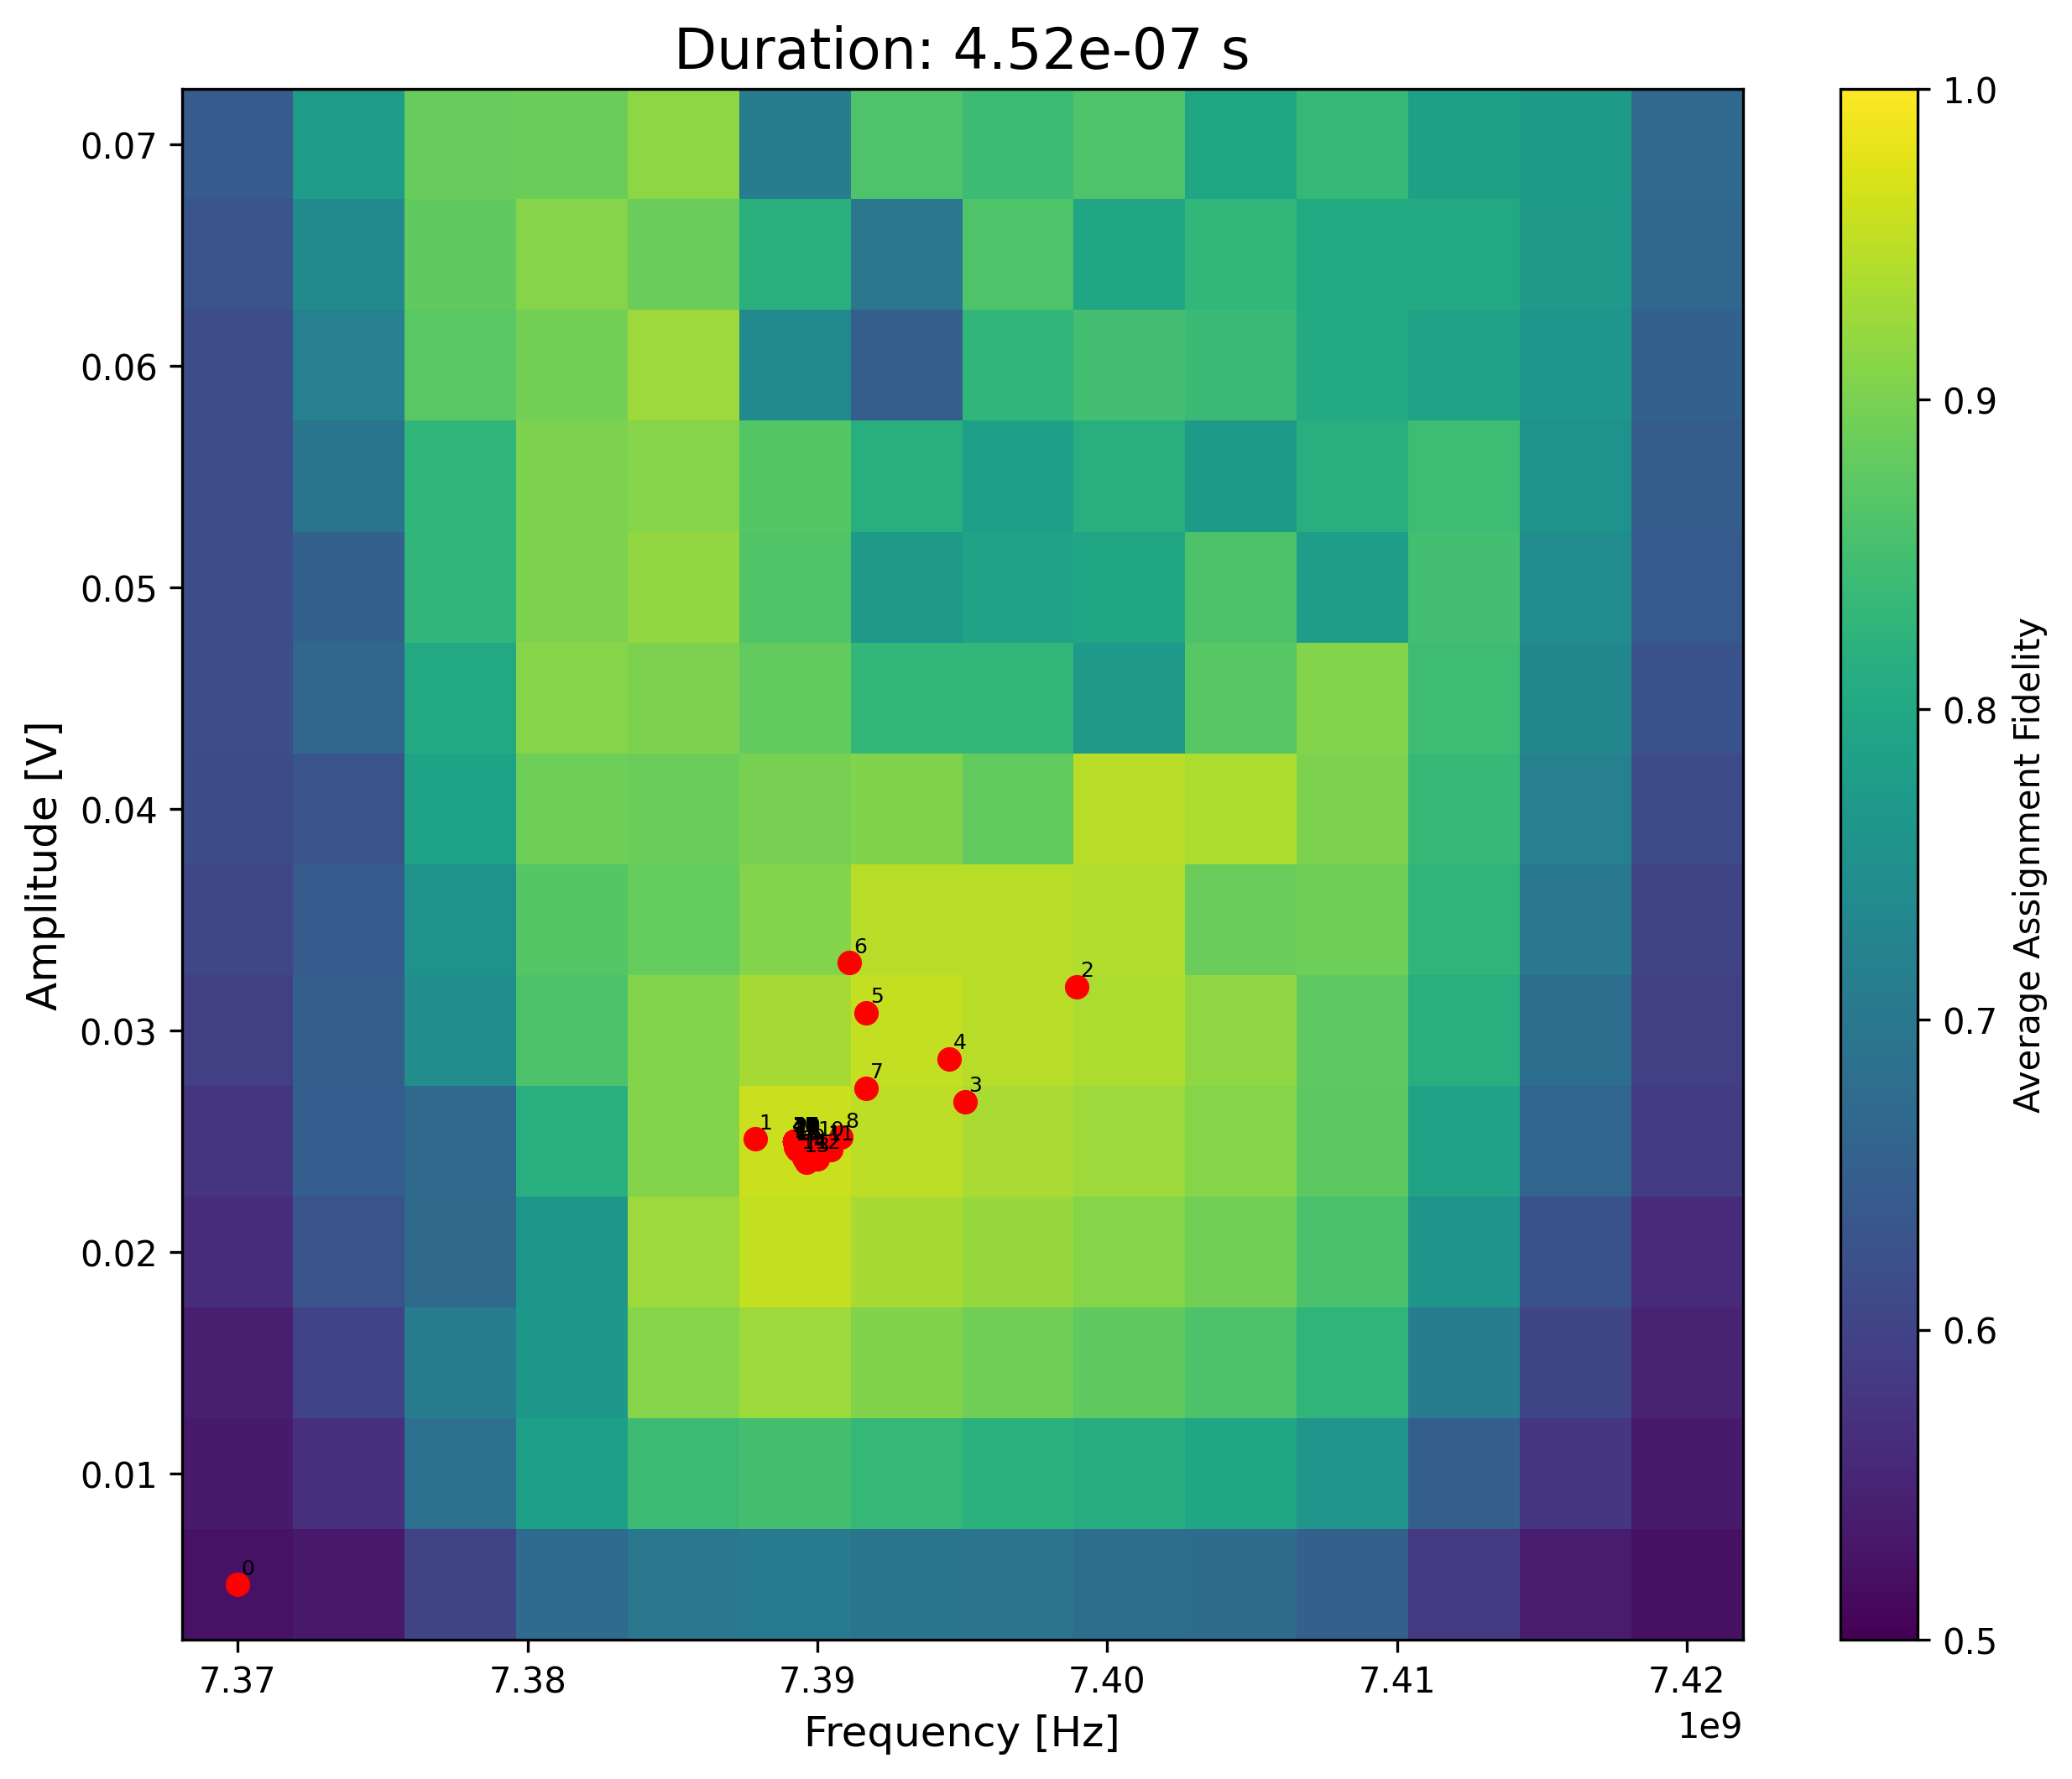

In [56]:
def plotSingleFidelityAndMean(frequency: np.ndarray, amplitude: np.ndarray, fidelity: np.ndarray, title: str, mean_evolution: np.ndarray, Ngen_array: np.ndarray) -> None:
    """
    Plot a single heatmap using imshow for frequency, amplitude, and fidelity.
    """
    # Reshape fidelity to 2D (if not already a grid)
    Z = fidelity.reshape(int(np.sqrt(len(amplitude))), int(np.sqrt(len(frequency))))

    # Calculate the extent of the axes for imshow
    dx = (frequency.max() - frequency.min()) / (Z.shape[1] - 1)  # Step size along x-axis
    dy = (amplitude.max() - amplitude.min()) / (Z.shape[0] - 1)  # Step size along y-axis

    extent = [
        frequency.min() - 0.5 * dx, frequency.max() + 0.5 * dx,  # x-axis range
        amplitude.min() - 0.5 * dy, amplitude.max() + 0.5 * dy   # y-axis range
    ]

    # Plot with imshow
    plt.figure(figsize=(10, 8), dpi=300)
    cmap = 'viridis'
    vmin, vmax = 0.5, 1  # Set fidelity range for consistent scaling

    im = plt.imshow(Z, extent=extent, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.scatter(mean_evolution[:,0],mean_evolution[:,1],color="red")

    # Add labels to scatter points
    for i, label in enumerate(Ngen_array):
        plt.annotate(
            str(label),
            (mean_evolution[i, 0], mean_evolution[i, 1]),
            textcoords="offset points",  # Offset the label from the point
            xytext=(3, 3),               # Offset values in points
            ha='center',                 # Horizontal alignment
            fontsize=6                   # Adjust fontsize if necessary
        )

    plt.colorbar(im, label="Average Assignment Fidelity")
    plt.title(str("Duration: " + title + " s"), fontsize=16)
    plt.xlabel("Frequency [Hz]", fontsize=12)
    plt.ylabel("Amplitude [V]", fontsize=12)
    plt.show()

Ngen_array = np.arange(Ngen)
print(Ngen_array)
plotSingleFidelityAndMean(frequency_test,amplitude_test,average_fidelity_test,str(duration),mean_evolution,Ngen_array)

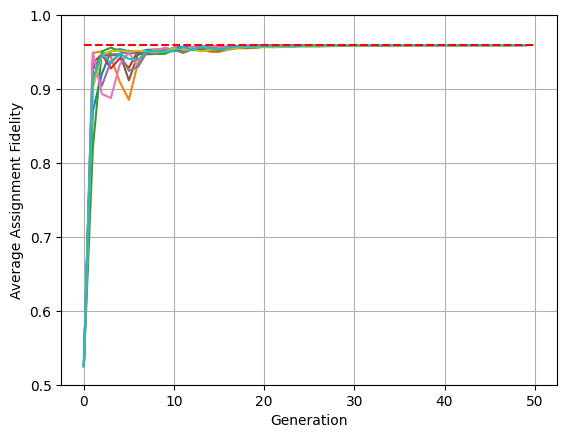

In [54]:
def cmaes_frequency_and_amplitude_plot_realisations(mean, sigma, popsize, Ngen,  minFreq, maxFreq, minAmpl, maxAmpl, Nreal, plot: bool):
    boundX = [0, 1]
    boundY = [0, 1]
    bounds = np.array([boundX, boundY])

    fidelity_realisations = np.zeros((Nreal,Ngen))

    if plot:
        plt.figure()
    for j in range(Nreal):    
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)
    
        deltaFreq = maxFreq - minFreq
        deltaAmpl = maxAmpl - minAmpl

        mean_fidelity = np.zeros(Ngen)
        # maxFidelity = np.zeros(Ngen)
        # coordinate = np.zeros((Ngen, 2))
        # mean_evolution = np.zeros((Ngen,2))
    
        for generation in range(Ngen):
            normalized_mean = optimizer.mean
            current_mean = np.copy(normalized_mean)
            current_mean[0] = current_mean[0] * deltaFreq + minFreq
            current_mean[1] = current_mean[1] * deltaAmpl + minAmpl
            mean_fidelity[generation] = fidelityEstimate(current_mean,frequency_test,amplitude_test,average_fidelity_test)[0]
            
            # print(fidelityEstimate(current_mean,frequency_test,amplitude_test,average_fidelity_test))
            # mean_evolution[generation,0] = optimizer.mean[0] * deltaFreq + minFreq
            # mean_evolution[generation,1] = optimizer.mean[1] * deltaAmpl + minAmpl
            normalized_freq = np.zeros(popsize)
            normalized_ampl = np.zeros(popsize)
            
            frequencies = np.zeros(popsize)
            amplitudes = np.zeros(popsize)
            
            for i in range(popsize):
                x = optimizer.ask()
                normalized_freq[i] = x[0]
                normalized_ampl[i] = x[1]
    
                frequencies[i] = x[0]*deltaFreq + minFreq
                amplitudes[i] = x[1]*deltaAmpl + minAmpl
                        
            normalized_freq_and_ampl = [(float(xi), float(yi)) for xi, yi in zip(normalized_freq, normalized_ampl)]
            freq_and_ampl = np.array([np.array([xi, yi]) for xi, yi in zip(frequencies, amplitudes)])
            # print(freq_and_ampl)
            objective_value = objective(freq_and_ampl,frequency_test, amplitude_test,average_fidelity_test)
    
            solutions = [(wi, float(vi)) for wi, vi in zip(normalized_freq_and_ampl, objective_value)]
            optimizer.tell(solutions)

        fidelity_realisations[j,:] = mean_fidelity

        if plot:
            plt.plot(range(Ngen),mean_fidelity,label = str("Realisation: " + str(j)))
            plt.xlabel("Generation")
            plt.ylabel("Average Assignment Fidelity")
        
    if plot:
        plt.ylim(0.5,1)
        plt.hlines(max(average_fidelity_test),0,Ngen, color = 'red', ls = "--")
        plt.grid()
        # plt.legend()
        plt.show()

    # normalized_mean = optimizer.mean
    # mean = np.copy(normalized_mean)
    # mean[0] = mean[0] * deltaFreq + minFreq
    # mean[1] = mean[1] * deltaAmpl + minAmpl
    # fidelity = fidelityEstimate(mean,frequency_test,amplitude_test,average_fidelity_test)
    return fidelity_realisations 

popsize = 10
sigma = 0.25 #1/4 of the domain 
mean = np.array([0.0,0.0])
minFreq = min(frequency_test)
maxFreq = max(frequency_test)
minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
Ngen = 50
Nreal = 10

fidelity_realisations = cmaes_frequency_and_amplitude_plot_realisations(mean, sigma, popsize, Ngen,  minFreq, maxFreq, minAmpl, maxAmpl, Nreal,True)

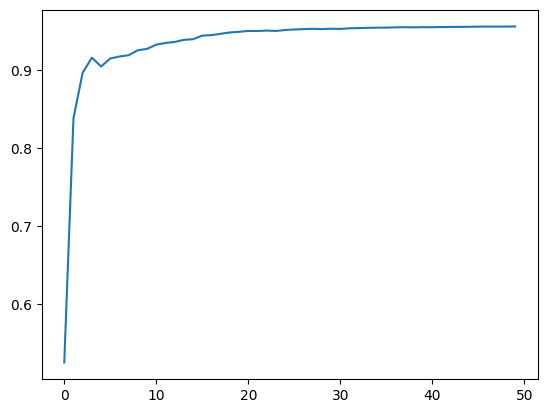

In [44]:
popsize = 3
sigma = 0.25 #1/4 of the domain 
mean = np.array([0.0,0.0])
minFreq = min(frequency_test)
maxFreq = max(frequency_test)
minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
Ngen = 50
Nreal = 100

fidelity_realisations = cmaes_frequency_and_amplitude_plot_realisations(mean, sigma, popsize, Ngen,  minFreq, maxFreq, minAmpl, maxAmpl, Nreal,False)

mean_fidelity_realisations = np.mean(fidelity_realisations,axis=0)
plt.plot(range(Ngen),mean_fidelity_realisations)
plt.show()

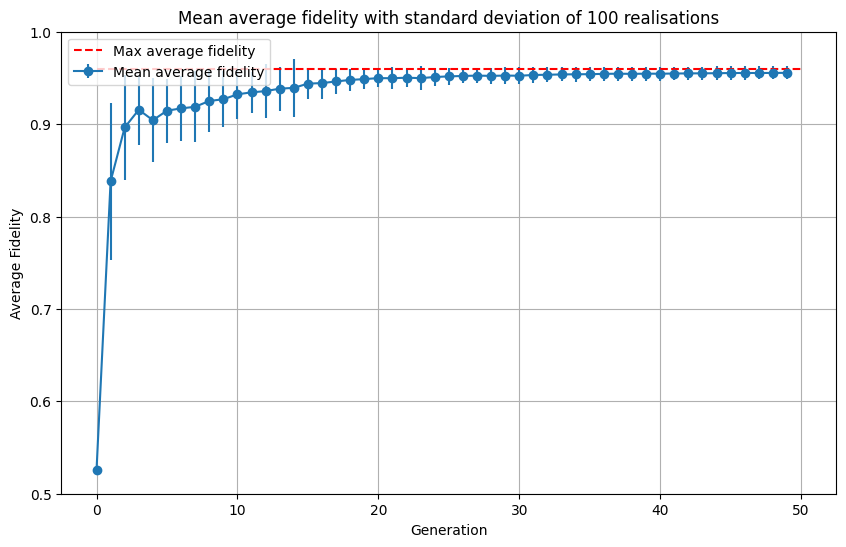

In [45]:
mean_fidelity_realisations = np.mean(fidelity_realisations,axis=0)
std_fidelity_realisations = np.std(fidelity_realisations,axis=0)

plt.figure(figsize=(10, 6))
plt.errorbar(range(Ngen), mean_fidelity_realisations, yerr=std_fidelity_realisations, fmt='-o',label="Mean average fidelity")
plt.hlines(max(average_fidelity_test),0,Ngen, color = 'red', ls = "--", label = "Max average fidelity")
plt.ylim(0.5,1)
plt.grid()
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Average Fidelity")
plt.title("Mean average fidelity with standard deviation of 100 realisations")
plt.show()

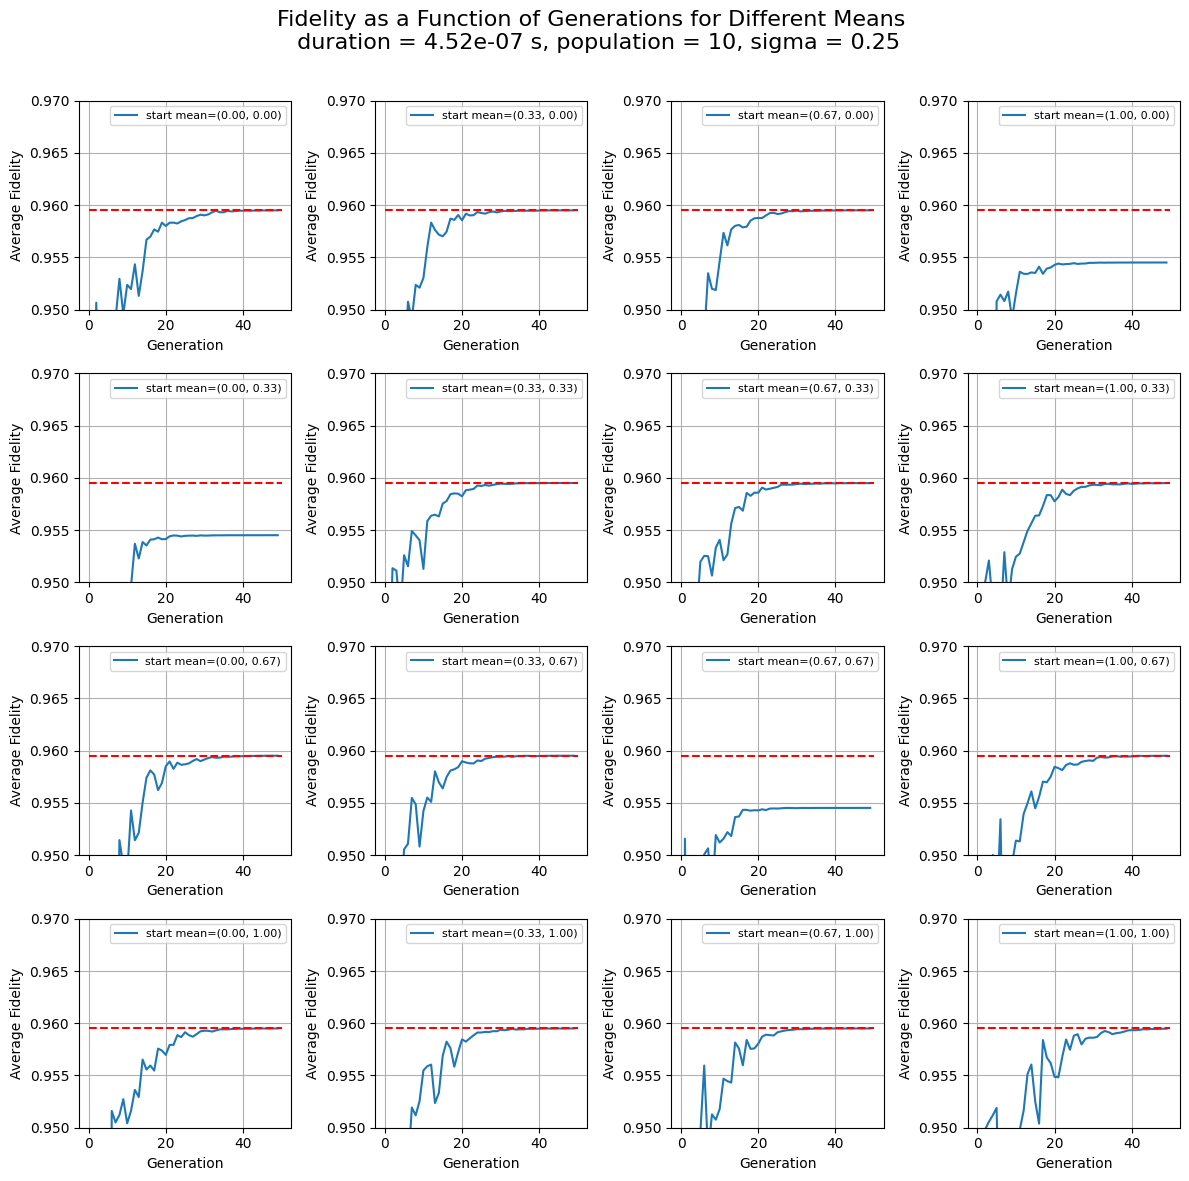

In [46]:
def objectiveSinglePoint(point,frequency,amplitude,fidelity):
    F = fidelityEstimate(point, frequency, amplitude, fidelity)
    return np.log(1-F)

# Parameters
popsize = 10
sigma = 0.25  # 1/4 of the domain

boundX = [0, 1]
boundY = [0, 1]
bounds = np.array([boundX, boundY])

minFreq = min(frequency_test)
maxFreq = max(frequency_test)
deltaFreq = maxFreq - minFreq

minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
deltaAmpl = maxAmpl - minAmpl

Ngen = 50

N_points = 4
# Grid for mean values
x = np.linspace(0, 1, N_points)
y = np.copy(x)
X, Y = np.meshgrid(x, y)

# Create subplots
fig, axes = plt.subplots(N_points, N_points, figsize=(12, 12))
fig.suptitle(f"Fidelity as a Function of Generations for Different Means \n duration = {duration:.3g} s, population = {popsize:.3g}, sigma = {sigma:.3g}", fontsize=16)

# Loop through each mean value
for i in range(len(x)):
    for j in range(len(y)):
        mean = np.array([X[i][j], Y[i][j]])
        
        # Initialize optimizer
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)
        
        maxFidelity = np.zeros(Ngen)
        coordinate = np.zeros((Ngen, 2))
        meanFidelity = np.zeros(Ngen)
        
        # Optimization process
        for generation in range(Ngen):
            solutions = []
            fid = 0
            mean_hat = np.copy(optimizer.mean)
            mean_hat[0] = mean_hat[0]*deltaFreq+minFreq
            mean_hat[1] = mean_hat[1]*deltaAmpl+minAmpl
        
            meanFidelity[generation] = fidelityEstimate(mean_hat,frequency_test,amplitude_test,average_fidelity_test)[0]
            for _ in range(optimizer.population_size):
                x = optimizer.ask()
                
                x_hat = np.copy(x)
                x_hat[0] = x_hat[0] * deltaFreq + minFreq
                x_hat[1] = x_hat[1] * deltaAmpl + minAmpl
                
                value = objectiveSinglePoint(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                
                tmpFidelity = fidelityEstimate(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                
                if tmpFidelity > fid:
                    maxFidelity[generation] = tmpFidelity[0]
                    coordinate[generation, :] = x_hat
                    fid = tmpFidelity
                
                solutions.append((x, value))
            
            optimizer.tell(solutions)

        # print(optimizer.mean)
        # Plot in the corresponding subplot
        ax = axes[i, j]
        ax.plot(range(Ngen), meanFidelity, label=f"start mean=({mean[0]:.2f}, {mean[1]:.2f})")
        # ax.set_title(f"Mean=({mean[0]:.2f}, {mean[1]:.2f})", fontsize=10)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Average Fidelity")
        ax.set_ylim([0.95,0.97])
        # ax.set_yscale('log')
        ax.hlines(max(average_fidelity_test),0,Ngen, color = 'red', ls = "--")
        ax.grid()
        ax.legend(fontsize=8)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.savefig("Fidelity as a function of generatios - mean.pdf")
plt.show()

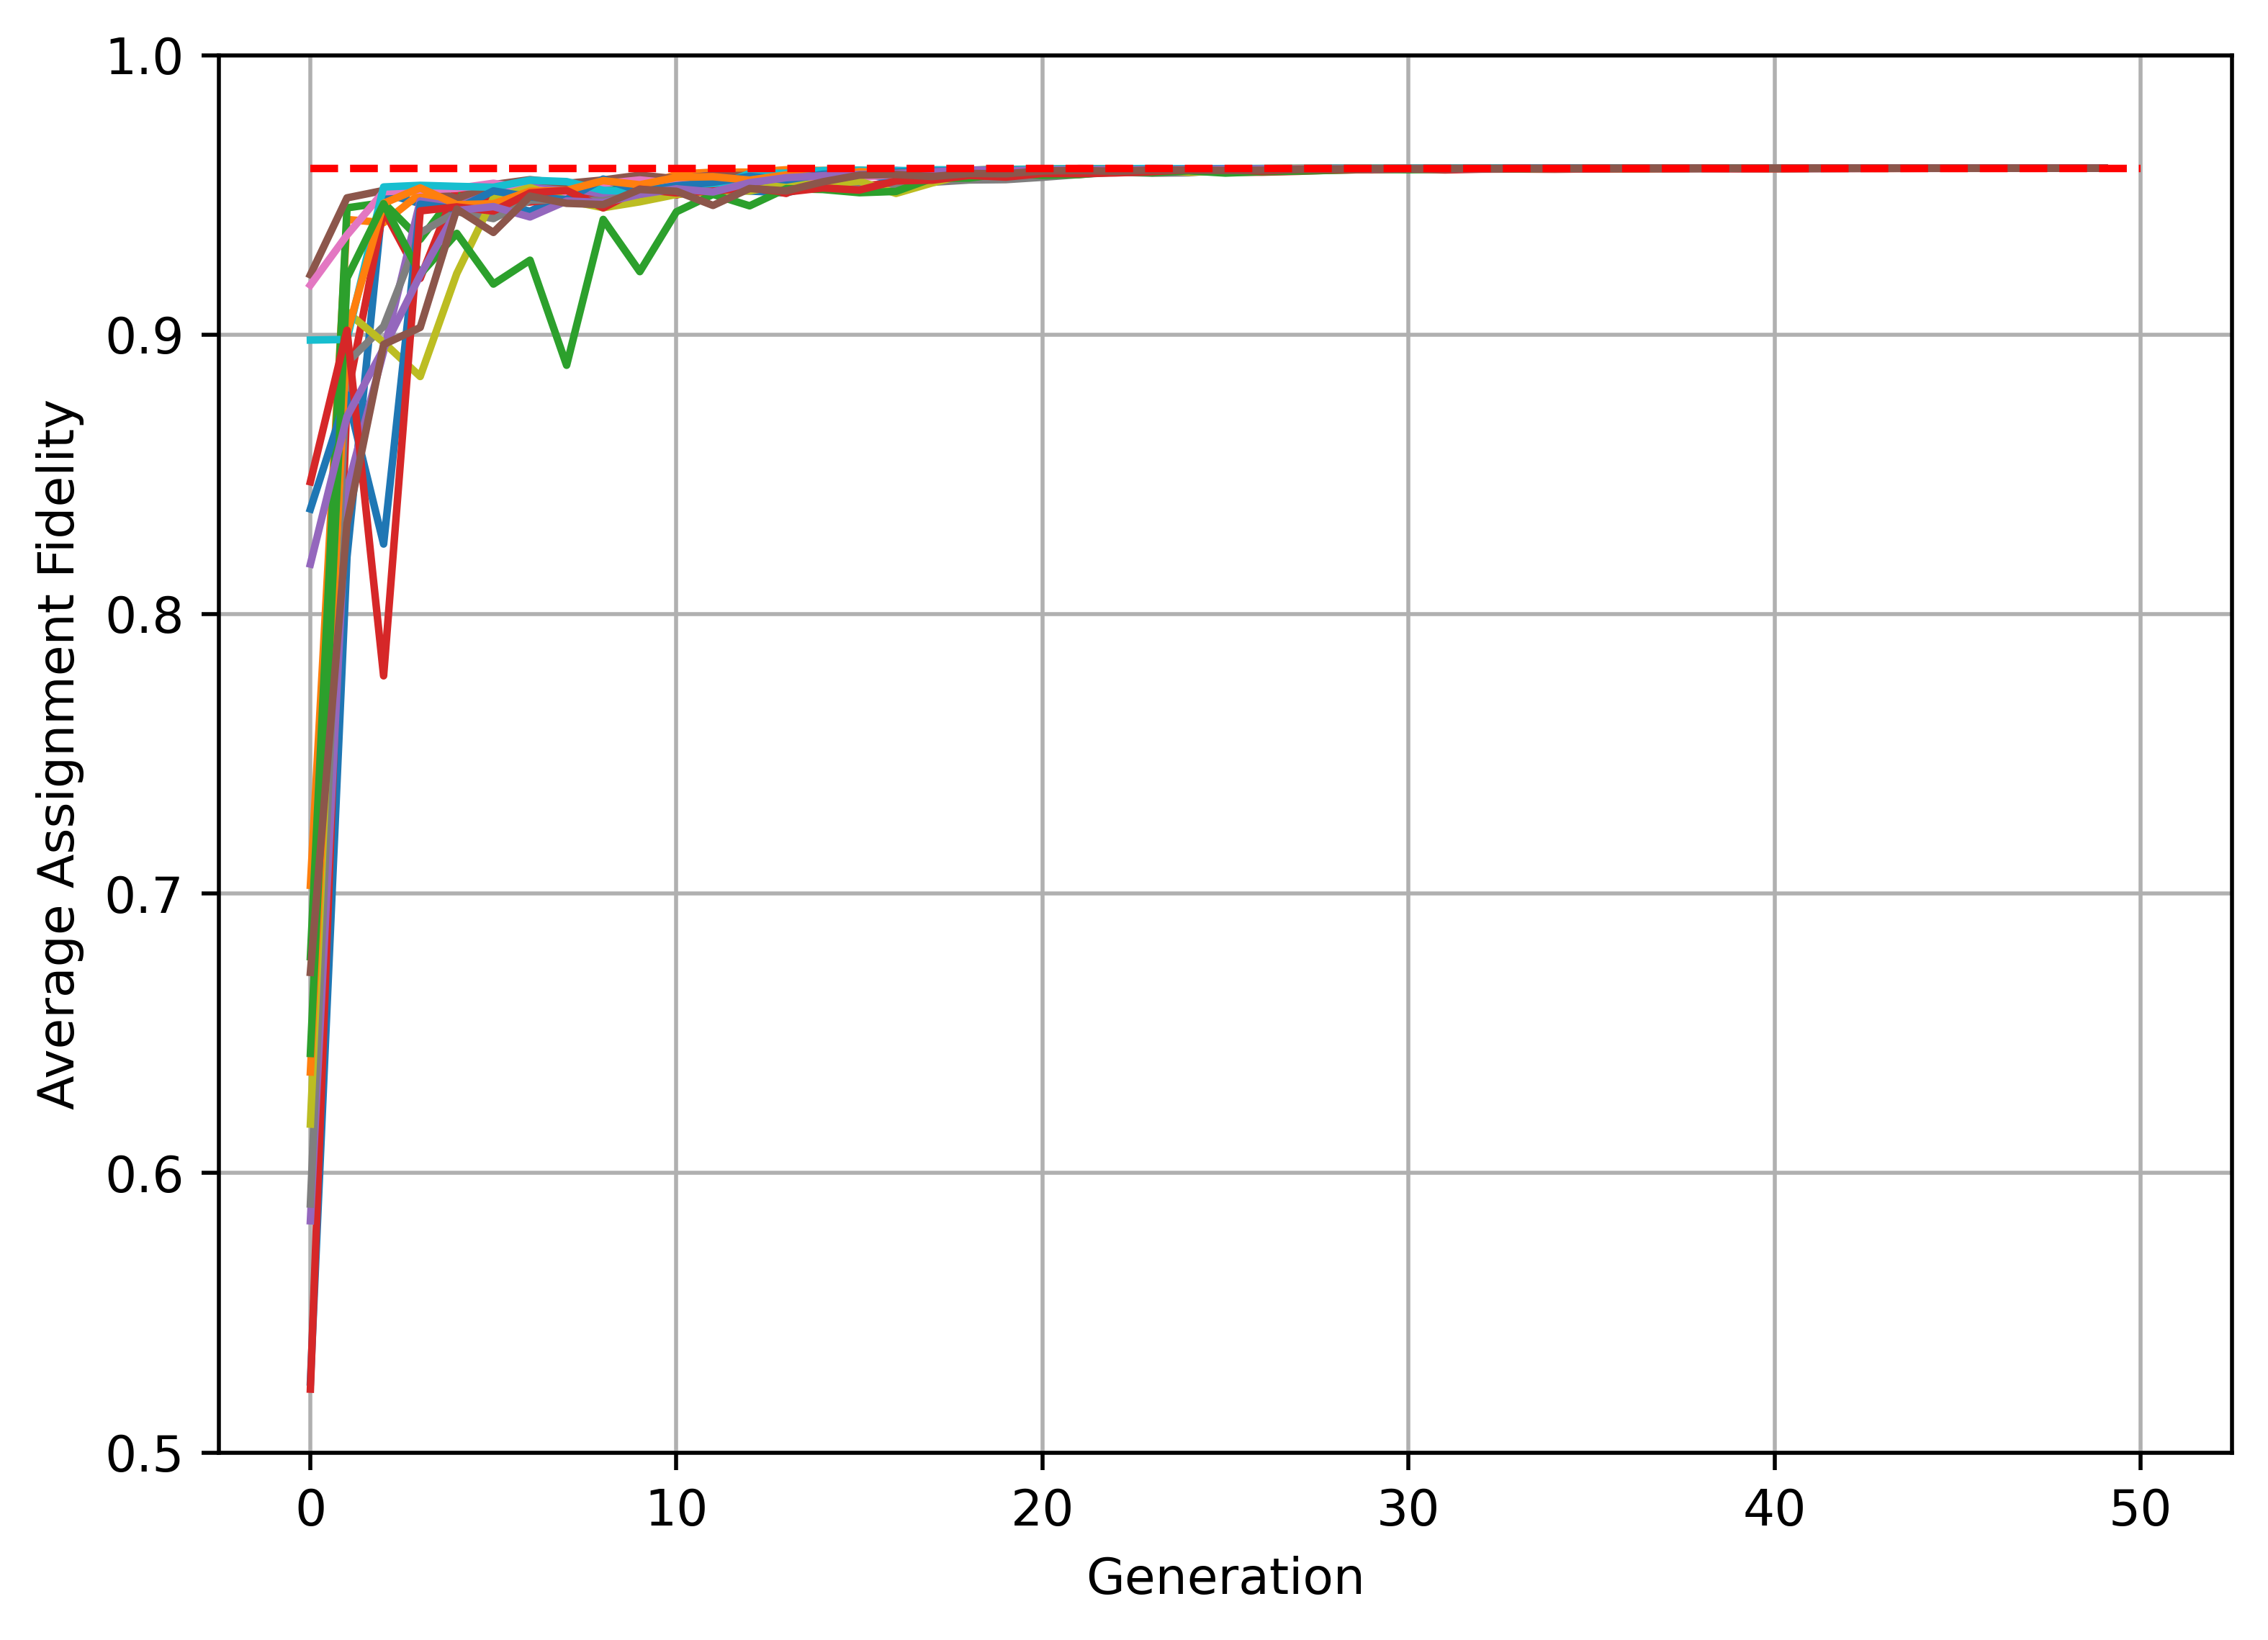

In [61]:
import numpy as np
import matplotlib.pyplot as plt

popsize = 10
N_points = 4
x = np.linspace(0, 1, N_points)
y = np.copy(x)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(dpi=500)
# fig.suptitle(f"Fidelity as a Function of Generations for Different Means \n duration = {duration:.3g} s, population = {popsize:.3g}, sigma = {sigma:.3g}", fontsize=16)

# Loop through each mean value and plot all lines on a single plot
for i in range(len(x)):
    for j in range(len(y)):
        mean = np.array([X[i][j], Y[i][j]])
        
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)
        
        meanFidelity = np.zeros(Ngen)
        
        for generation in range(Ngen):
            solutions = []
            mean_hat = np.copy(optimizer.mean)
            mean_hat[0] = mean_hat[0] * deltaFreq + minFreq
            mean_hat[1] = mean_hat[1] * deltaAmpl + minAmpl
            
            meanFidelity[generation] = fidelityEstimate(mean_hat, frequency_test, amplitude_test, average_fidelity_test)[0]
            
            for _ in range(optimizer.population_size):
                x = optimizer.ask()
                x_hat = np.copy(x)
                x_hat[0] = x_hat[0] * deltaFreq + minFreq
                x_hat[1] = x_hat[1] * deltaAmpl + minAmpl
                value = objectiveSinglePoint(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                solutions.append((x, value))
            
            optimizer.tell(solutions)
        
        ax.plot(range(Ngen), meanFidelity, label=f"start mean=({mean[0]:.2f}, {mean[1]:.2f})")

# Formatting
ax.set_xlabel("Generation")
ax.set_ylabel("Average Assignment Fidelity")
ax.set_ylim([0.5, 1])
ax.hlines(max(average_fidelity_test), 0, Ngen, color='red', linestyle="--", label="Max Avg Fidelity")
ax.grid()
# ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
# Parameters
popsize = 10
sigma = 0.25  # 1/4 of the domain

boundX = [0, 1]
boundY = [0, 1]
bounds = np.array([boundX, boundY])

minFreq = min(frequency_test)
maxFreq = max(frequency_test)
deltaFreq = maxFreq - minFreq

minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
deltaAmpl = maxAmpl - minAmpl

Ngen = 50

N_points = 4
# Grid for mean values
x = np.linspace(0, 1, N_points)
y = np.copy(x)
X, Y = np.meshgrid(x, y)

# Create subplots
fig, axes = plt.subplots(N_points, N_points, figsize=(12, 12))
fig.suptitle(f"Fidelity as a Function of Generations for Different Means \n duration = {duration:.3g} s, population = {popsize:.3g}, sigma = {sigma:.3g}", fontsize=16)

# Loop through each mean value
for i in range(len(x)):
    for j in range(len(y)):
        mean = np.array([X[i][j], Y[i][j]])
        
        # Initialize optimizer
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)
        
        maxFidelity = np.zeros(Ngen)
        coordinate = np.zeros((Ngen, 2))
        meanFidelity = np.zeros(Ngen)
        
        # Optimization process
        for generation in range(Ngen):
            solutions = []
            fid = 0
            mean_hat = np.copy(optimizer.mean)
            mean_hat[0] = mean_hat[0]*deltaFreq+minFreq
            mean_hat[1] = mean_hat[1]*deltaAmpl+minAmpl
        
            meanFidelity[generation] = fidelityEstimate(mean_hat,frequency_test,amplitude_test,average_fidelity_test)[0]
            for _ in range(optimizer.population_size):
                x = optimizer.ask()
                
                x_hat = np.copy(x)
                x_hat[0] = x_hat[0] * deltaFreq + minFreq
                x_hat[1] = x_hat[1] * deltaAmpl + minAmpl
                
                value = objective(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                
                tmpFidelity = fidelityEstimate(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                
                if tmpFidelity > fid:
                    maxFidelity[generation] = tmpFidelity[0]
                    coordinate[generation, :] = x_hat
                    fid = tmpFidelity
                
                solutions.append((x, value))
            
            optimizer.tell(solutions)
        
        # Plot in the corresponding subplot
        ax = axes[i, j]
        ax.plot(range(Ngen), meanFidelity, label=f"start mean=({mean[0]:.2f}, {mean[1]:.2f})")
        # ax.set_title(f"Mean=({mean[0]:.2f}, {mean[1]:.2f})", fontsize=10)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Average Fidelity")
        ax.set_ylim([0.5,1])
        # ax.set_yscale('log')
        ax.hlines(max(average_fidelity_test),0,Ngen, color = 'red', ls = "--")
        ax.grid()
        ax.legend(fontsize=8)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("Fidelity as a function of generatios - mean 0.5 to 1.pdf")
plt.show()

4.315376281738281e-05


0.0001888275146484375
